In [17]:
import os
import numpy as np
from Tool import PDEBaseSolver
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [18]:
def cal_beta(x, gamma):
    beta = 6 * np.cos(gamma * np.arccos(x))
    # beta = np.ones(len(x))
    # for idx, val in enumerate(x):
    #        beta[idx] = 6 * math.cos(gamma * math.acos(val))
    return beta

def cal_initial_state(x):
    """
    设置初始条件，结合空间变化和随机扰动。
    """
    list_initial_condition = []
    
    # 基于正弦函数的空间变化
    constant_1 = np.random.uniform(1, 5)
    constant_2 = np.random.uniform(1, 5)
    # u_initial = constant_1 * np.sin(np.pi * x) + np.random.normal(0, 0.1, len(x))
    # u_hat_initial = constant_2 * np.cos(np.pi * x) + np.random.normal(0, 0.1, len(x))
    u_initial = constant_1 * 5 * np.ones(len(x))
    u_hat_initial = constant_2 * 5 * np.ones(len(x))
    
    # 添加到初始条件列表
    list_initial_condition.append(u_initial)
    list_initial_condition.append(u_hat_initial)
    
    return list_initial_condition

def solveKernelFunction(beta, dx):
    a = len(beta)
    kernel = np.zeros(a)
    for i in range (0, a):
        kernelIntegral = 0
        for j in range(0, i):
            kernelIntegral += (kernel[i-j] * beta[j])*dx
        kernel[i] = kernelIntegral - beta[i]
    return np.flip(kernel)

def solveControl(u, kernel, dx):
    res = 0
    for i in range(0, len(u)):
        res += kernel[i]*u[i]
    return res*dx

In [19]:
class Transport_solver(PDEBaseSolver):
    def __init__(self, cal_beta_function, initial_condition_function, gama, solveKernelFunction, solveControl, **keyword):
        super().__init__(**keyword)
        self.t = np.linspace(0, self.T, self.nt)
        self.beta_function = cal_beta_function
        self.initial_condition_function = initial_condition_function
        self.gama = gama

        self.beta = self.beta_function(self.x, self.gama)
        self.kernel = solveKernelFunction(self.beta, self.dx)
        self.solveControl = solveControl

        # 假设 initial_condition_function 返回两个状态（主系统与观测器）
        self.initial_u, self.initial_u_hat = self.initial_condition_function(self.x)

        print(f"    beta is generated. Shape of beta_function is : {self.beta.shape}")

    def simulation(self, control=0):
        
        Nx = self.nx
        dx = self.dx
        dt = self.dt

        self.u_hat = self.u.copy()

        # 初始条件
        self.u[0] = self.initial_u
        self.u_hat[0] = self.initial_u_hat

        for i in range(1, self.nt):
            U_0 = self.u[i-1, 0]
            self.u[i, -1] = self.solveControl(self.u_hat[i - 1], self.kernel, self.dx)
            self.u_hat[i, -1] = self.solveControl(self.u_hat[i - 1], self.kernel, self.dx)
            for j in range(0, Nx-1):
                self.u[i, j] = self.u[i - 1, j] + dt * (
                    (self.u[i - 1, j + 1] - self.u[i - 1, j]) / dx + self.beta[j] * U_0
                )
                # self.u_hat[i, j] = ...  # 在此添加观测器更新逻辑
                self.u_hat[i, j] = self.u_hat[i - 1, j] + dt * (
                    (self.u_hat[i - 1, j + 1] - self.u_hat[i - 1, j]) / dx + self.beta[j] * U_0 
                )

        return self.u, self.u_hat         
        

In [20]:
# Timestep and spatial step for PDE Solver
T = 5
# 0.0001
dt = 0.0001
X = 1
# 0.01
dx = 0.01

gama = 3

In [21]:
Parameters = {
    "X": X,
    "dx": dx,
    "T": T,
    "dt": dt,
    "cal_beta_function": cal_beta,
    "gama" : gama,
    "initial_condition_function" : cal_initial_state,
    "solveKernelFunction" : solveKernelFunction,
    "solveControl" : solveControl
}

In [22]:
Solver = Transport_solver(**Parameters)
u_list = Solver.simulation()

 👀 State variable discretization completed. Shape of u: (50000, 100)
    beta is generated. Shape of beta_function is : (100,)


In [24]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    # 子图的行数和列数
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    # fraction 为图形宽度占文档宽度的比例，默认为1
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2
    
    # 换算为英寸单位
    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

图像已保存到: /Users/thy/Desktop/Work/Project/For-observer/Observer/result/Output feedback.pdf


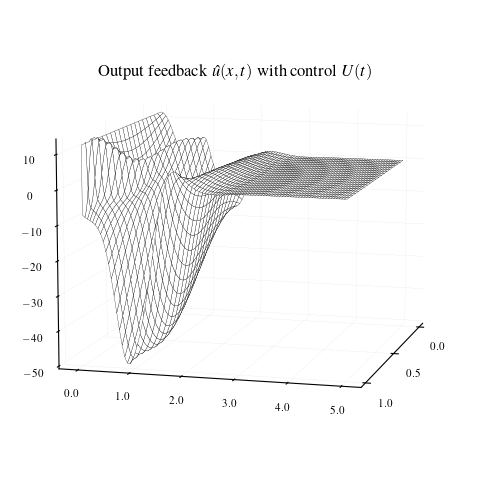

In [26]:
# ✅ 创建图形
fig = plt.figure(figsize=set_size(522, 0.99, (1, 1)))
# fig.suptitle("openloop_contrast", fontsize=13, y=0.96)

# ✅ 左右两个子图组
subfigs = fig.subfigures(nrows=1, ncols=1)
subfigs.subplots_adjust(left=0.07, right=0.95, bottom=0.05, top=1.1)
subfigs.suptitle(r"Output feedback $\hat{u}(x, t)$ with control $U(t)$")

# ✅ 创建一个 3D 子图
ax = subfigs.subplots(1, 1, subplot_kw={"projection": "3d"})


for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "black"
    axis._axinfo['grid']['linewidth'] = 0.15
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d3d3d3"
    axis.set_pane_color((1, 1, 1))

# ✅ 加载数据
meshx, mesht = np.meshgrid(Solver.x, Solver.t)
uopen = Solver.u
# u_hat_open = Solver.u_hat

# ✅ 绘制曲面

ax.plot_surface(
        meshx, mesht, uopen,
        edgecolor="black", lw=0.2, rstride=500, cstride=5,
        alpha=1, color="white", shade=False, rasterized=True, antialiased=True
    )

ax.view_init(10, 15)
ax.zaxis.set_rotate_label(False)
ax.set_xticks([0, 0.5, 1])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


# 保存图片
folder_path = os.path.expanduser("/Users/thy/Desktop/Work/Project/For-observer/Observer/result")  
os.makedirs(folder_path, exist_ok=True)

save_path = os.path.join(folder_path, r"Output feedback.pdf")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"图像已保存到: {save_path}")

图像已保存到: /Users/thy/Desktop/Work/Project/For-observer/Observer/result/openloop_u(t).pdf


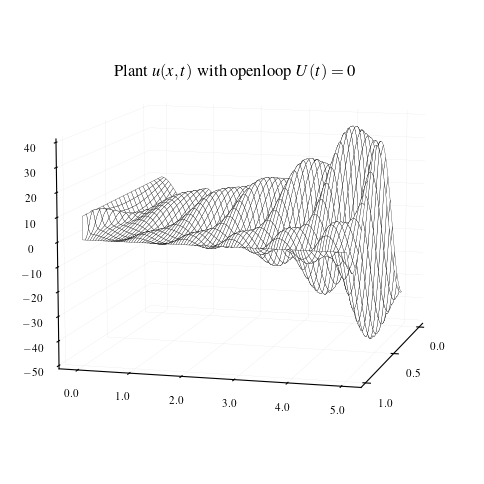

In [ ]:
# # ✅ 创建图形
# fig = plt.figure(figsize=set_size(522, 0.99, (1, 1)))
# # fig.suptitle("openloop_contrast", fontsize=13, y=0.96)

# # ✅ 左右两个子图组
# subfigs = fig.subfigures(nrows=1, ncols=1)
# subfigs.subplots_adjust(left=0.07, right=0.95, bottom=0.05, top=1.1)
# subfigs.suptitle(r"Plant $u(x, t)$ with openloop $U(t)=0$")

# # ✅ 创建一个 3D 子图
# ax = subfigs.subplots(1, 1, subplot_kw={"projection": "3d"})


# for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
#     axis._axinfo['axisline']['linewidth'] = 1
#     axis._axinfo['axisline']['color'] = "black"
#     axis._axinfo['grid']['linewidth'] = 0.15
#     axis._axinfo['grid']['linestyle'] = "--"
#     axis._axinfo['grid']['color'] = "#d3d3d3"
#     axis.set_pane_color((1, 1, 1))

# # ✅ 加载数据
# meshx, mesht = np.meshgrid(Solver.x, Solver.t)
# uopen = Solver.u
# # u_hat_open = Solver.u_hat

# # ✅ 绘制曲面

# ax.plot_surface(
#         meshx, mesht, uopen,
#         edgecolor="black", lw=0.2, rstride=500, cstride=5,
#         alpha=1, color="white", shade=False, rasterized=True, antialiased=True
#     )

# ax.view_init(10, 15)
# ax.zaxis.set_rotate_label(False)
# ax.set_xticks([0, 0.5, 1])
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


# # 保存图片
# folder_path = os.path.expanduser("/Users/thy/Desktop/Work/Project/For-observer/Observer/result")  
# os.makedirs(folder_path, exist_ok=True)

# save_path = os.path.join(folder_path, r"openloop_u(t).pdf")
# plt.savefig(save_path, dpi=300, bbox_inches="tight")
# print(f"图像已保存到: {save_path}")

图像已保存到: /Users/thy/Desktop/Work/Project/For-observer/Observer/result/openloop_Observer_u(t).pdf


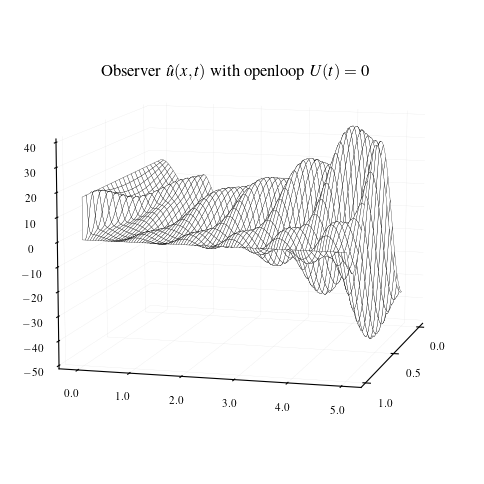

In [ ]:
# # ✅ 创建图形
# fig = plt.figure(figsize=set_size(522, 0.99, (1, 1)))
# # fig.suptitle("openloop_contrast", fontsize=13, y=0.96)

# # ✅ 左右两个子图组
# subfigs = fig.subfigures(nrows=1, ncols=1)
# subfigs.subplots_adjust(left=0.07, right=0.95, bottom=0.05, top=1.1)
# subfigs.suptitle(r"Observer $\hat{u}(x, t)$ with openloop $U(t)=0$")

# # ✅ 创建一个 3D 子图
# ax = subfigs.subplots(1, 1, subplot_kw={"projection": "3d"})


# for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
#     axis._axinfo['axisline']['linewidth'] = 1
#     axis._axinfo['axisline']['color'] = "black"
#     axis._axinfo['grid']['linewidth'] = 0.15
#     axis._axinfo['grid']['linestyle'] = "--"
#     axis._axinfo['grid']['color'] = "#d3d3d3"
#     axis.set_pane_color((1, 1, 1))

# # ✅ 加载数据
# meshx, mesht = np.meshgrid(Solver.x, Solver.t)
# uopen = Solver.u_hat
# # u_hat_open = Solver.u_hat

# # ✅ 绘制曲面

# ax.plot_surface(
#         meshx, mesht, uopen,
#         edgecolor="black", lw=0.2, rstride=500, cstride=5,
#         alpha=1, color="white", shade=False, rasterized=True, antialiased=True
#     )

# ax.view_init(10, 15)
# ax.zaxis.set_rotate_label(False)
# ax.set_xticks([0, 0.5, 1])
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


# # 保存图片
# folder_path = os.path.expanduser("/Users/thy/Desktop/Work/Project/For-observer/Observer/result")  
# os.makedirs(folder_path, exist_ok=True)

# save_path = os.path.join(folder_path, r"openloop_Observer_u(t).pdf")
# plt.savefig(save_path, dpi=300, bbox_inches="tight")
# print(f"图像已保存到: {save_path}")

图像已保存到: /Users/thy/Desktop/Work/Project/For-observer/Observer/result/openloop_Observer_u(t).pdf


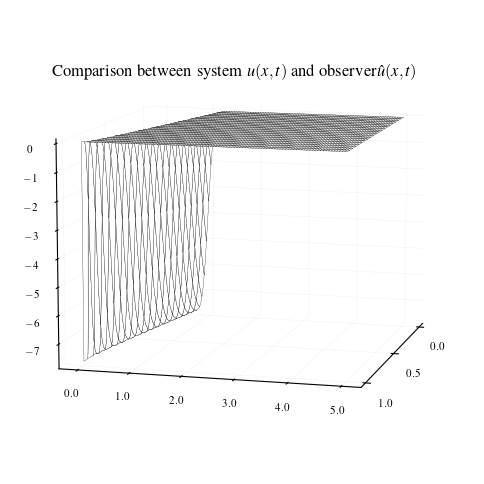

In [ ]:
# # ✅ 创建图形
# fig = plt.figure(figsize=set_size(522, 0.99, (1, 1)))
# # fig.suptitle("openloop_contrast", fontsize=13, y=0.96)

# # ✅ 左右两个子图组
# subfigs = fig.subfigures(nrows=1, ncols=1)
# subfigs.subplots_adjust(left=0.07, right=0.95, bottom=0.05, top=1.1)
# subfigs.suptitle(r"Comparison between system $u(x,t)$ and observer$\hat{u}(x,t)$")

# # ✅ 创建一个 3D 子图
# ax = subfigs.subplots(1, 1, subplot_kw={"projection": "3d"})


# for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
#     axis._axinfo['axisline']['linewidth'] = 1
#     axis._axinfo['axisline']['color'] = "black"
#     axis._axinfo['grid']['linewidth'] = 0.15
#     axis._axinfo['grid']['linestyle'] = "--"
#     axis._axinfo['grid']['color'] = "#d3d3d3"
#     axis.set_pane_color((1, 1, 1))

# # ✅ 加载数据
# meshx, mesht = np.meshgrid(Solver.x, Solver.t)
# data = Solver.u - Solver.u_hat 
# # u_hat_open = Solver.u_hat

# # ✅ 绘制曲面

# ax.plot_surface(
#         meshx, mesht, data,
#         edgecolor="black", lw=0.2, rstride=500, cstride=5,
#         alpha=1, color="white", shade=False, rasterized=True, antialiased=True
#     )

# ax.view_init(10, 15)
# ax.zaxis.set_rotate_label(False)
# ax.set_xticks([0, 0.5, 1])
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


# # 保存图片
# # folder_path = os.path.expanduser("/Users/thy/Desktop/Work/Project/For-observer/Observer/result")  
# # os.makedirs(folder_path, exist_ok=True)

# save_path = os.path.join(folder_path, r"openloop_Observer_u(t).pdf")
# plt.savefig(save_path, dpi=300, bbox_inches="tight")
# print(f"图像已保存到: {save_path}")

图像已保存到: /Users/thy/Desktop/Work/Project/For-observer/Observer/result/openloopObserver Estimation Error.pdf


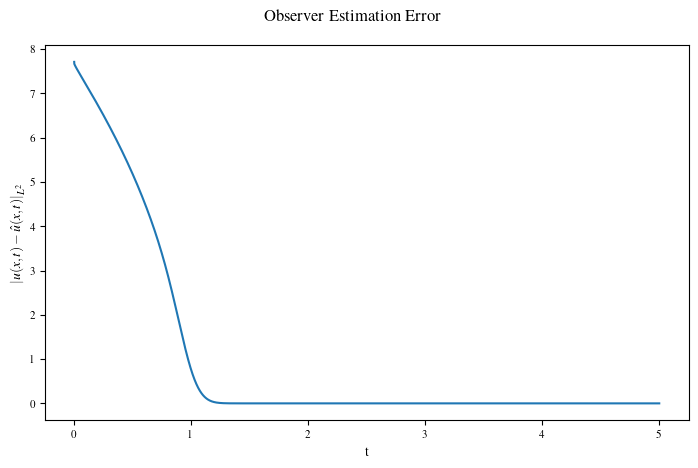

In [ ]:
# l2_norm = np.sqrt(np.sum(data**2, axis=1) * Solver.dx)  # L2 范数在空间上对每个时刻 t
# l2_norm.shape

# # ✅ 创建图形
# fig = plt.figure(figsize=set_size(522, 0.99, (1, 1)))
# # fig.suptitle("openloop_contrast", fontsize=13, y=0.96)

# # ✅ 创建子图
# subfigs = fig.subfigures(nrows=1, ncols=1)
# subfigs.subplots_adjust(left=0.07, right=0.97, bottom=0.05, top=0.9)
# subfigs.suptitle("Observer Estimation Error")

# #
# ax = subfigs.subplots(1, 1)
# ax.plot(Solver.t, l2_norm)
# ax.set_xlabel("t")
# ax.set_ylabel(r"$|u(x,t)-\hat{u}(x,t)|_{L^2}$")

# save_path = os.path.join(folder_path, r"openloopObserver Estimation Error.pdf")
# plt.savefig(save_path, dpi=300, bbox_inches="tight")
# print(f"图像已保存到: {save_path}")

